In [1]:
import numpy as np
import pandas as pd
import requests
from io import StringIO
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

## Load Data

In [2]:
df = pd.read_csv('https://www.dropbox.com/s/x7p6qmenhlg63pq/national_history.csv?dl=1', \
                 thousands = ',', infer_datetime_format = True)

In [3]:
df.head(5)

Date  State (or territory)  New tests  \
0  10/19/2020                    56    1200056   
1  10/18/2020                    56     978769   
2  10/17/2020                    56    1188950   
3  10/16/2020                    56    1141550   
4  10/15/2020                    56    1021863   

   Cases (confirmed plus probable)  Negative PCR tests (people)  \
0                          8171703                    109195067   
1                          8114555                    108172840   
2                          8065633                    107406051   
3                          8007690                    106457881   
4                          7939566                    105479593   

   Cumulative hospitalized/Ever hospitalized  \
0                                   436817.0   
1                                   435133.0   
2                                   434280.0   
3                                   432745.0   
4                                   430887.0   

   Currently hospitalized/Now hospitalized  Deaths (confirmed and probable)  \
0                                  37744.0                         211846.0   
1                                  36415.0                         211390.0   
2                                  37392.0                         210997.0   
3                                  37336.0                         210217.0   
4                                  37308.0                         209340.0   

   Recovered  Total test results  
0  3272603.0           126033173  
1  3234183.0           124833117  
2  3220607.0           123854348  
3  3197539.0           122665398  
4  3177397.0           121523848

In [4]:
df.shape
print(f"Data shape: {df.shape[0]} rows x {df.shape[1]} cols")

Data shape: 272 rows x 10 cols


In [5]:
df.dtypes

Date                                          object
State (or territory)                           int64
New tests                                      int64
Cases (confirmed plus probable)                int64
Negative PCR tests (people)                    int64
Cumulative hospitalized/Ever hospitalized    float64
Currently hospitalized/Now hospitalized      float64
Deaths (confirmed and probable)              float64
Recovered                                    float64
Total test results                             int64
dtype: object

## Quick Features Overview

-`Date`: date                         
-`State (or territory)`:state                       
-`New tests`: Daily increase in `Total test results`               
-`Cases (confirmed plus probable)`: Cumulative total number of confirmed plus probable cases of COVID-19 <br />
-`Negative PCR tests (people)`: Cumulative total number of unique people with a completed PCR test that returns negative <br /> 
-`Cumulative hospitalized/Ever hospitalized`: Cumulative total number of individuals who have ever been hospitalized       
-`Currently hospitalized/Now hospitalized`: Number of individuals who are currently hospitalized with COVID-19         
-`Deaths (confirmed and probable)`: Cumulative total fatalities with confirmed OR probable COVID-19 case diagnosis         
-`Recovered `: Cumulative total number of people that are identified as recovered from COVID-19                          
-`Total test results`: Cumulative total of people who were tested      


In [6]:
df.columns

Index(['Date', 'State (or territory)', 'New tests',
       'Cases (confirmed plus probable)', 'Negative PCR tests (people)',
       'Cumulative hospitalized/Ever hospitalized',
       'Currently hospitalized/Now hospitalized',
       'Deaths (confirmed and probable)', 'Recovered', 'Total test results'],
      dtype='object')

The existing column names are too long. Let's replace them with shortened names.

In [7]:
#Let's rename the column 

new_col_names ={
    'Date':'date', 
    'State (or territory)':'state', 
    'New tests':'dailyTest',
    'Cases (confirmed plus probable)': 'cumPosResult', 
    'Negative PCR tests (people)':'cumNegResult',
    'Cumulative hospitalized/Ever hospitalized':'cumHospital',
    'Currently hospitalized/Now hospitalized':'curtHospital',
    'Deaths (confirmed and probable)':'cumDeath', 
    'Recovered':'cumRecover', 
    'Total test results':'totTestResult'
   
}

df.rename(columns = new_col_names, inplace = True)

**Data Period**

In [8]:
df['date'] = pd.to_datetime(df['date']).dt.date
print(f"First Date:{df['date'].min()}\n Last Date:{df['date'].max()}")

First Date:2020-01-22
 Last Date:2020-10-19


**Check data missingness**

In [9]:
df.isna().sum(axis=0)

date              0
state             0
dailyTest         0
cumPosResult      0
cumNegResult      0
cumHospital      42
curtHospital     55
cumDeath         19
cumRecover       63
totTestResult     0
dtype: int64

In [10]:
df[df.isna().any(axis=1)]

date  state  dailyTest  cumPosResult  cumNegResult  cumHospital  \
209  2020-03-24     56      71336         62371        321763       5117.0   
210  2020-03-23     56      59689         51602        263068       3937.0   
211  2020-03-22     56      49032         40163        216174       3023.0   
212  2020-03-21     56      50660         31038        179718       2020.0   
213  2020-03-20     56      41977         24245        141090        108.0   
..          ...    ...        ...           ...           ...          ...   
267  2020-01-26      2          0             0             0          NaN   
268  2020-01-25      2          0             0             0          NaN   
269  2020-01-24      2          0             0             0          NaN   
270  2020-01-23      2          1             0             0          NaN   
271  2020-01-22      2          0             0             0          NaN   

     curtHospital  cumDeath  cumRecover  totTestResult  
209        3902.0     815.0         NaN         424271  
210        2770.0     581.0         NaN         352935  
211        2155.0     480.0         NaN         293246  
212        1436.0     334.0         NaN         244214  
213        1042.0     272.0         NaN         193554  
..            ...       ...         ...            ...  
267           NaN       NaN         NaN              2  
268           NaN       NaN         NaN              2  
269           NaN       NaN         NaN              2  
270           NaN       NaN         NaN              2  
271           NaN       NaN         NaN              1  

[63 rows x 10 columns]

We can see that the missing values are only shown in the early dates of the dateset, and Nan can be replaced with '0'.

In [11]:
df.fillna(0, inplace = True)

<AxesSubplot:>

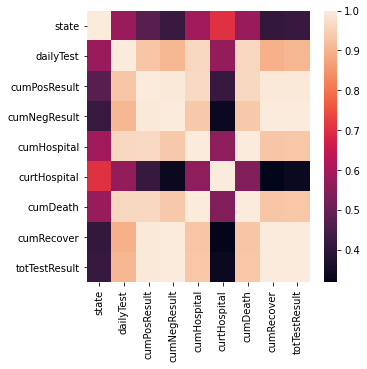

In [14]:
import seaborn as sns
plt.figure(figsize=(5,5))
sns.heatmap(df.corr())

### Key Observation
- We notice from the above heatmap features are highly correlated because the cumulative information tend to highly correlated, we have to introduce **feature generation** to minimize multicolinearity.

- Most of the features are 'cumulative values', but we need also 'daily statistics', which were taken care of in the following feature engineering section.

In [15]:
cum_cols = ['cumPosResult', 
            'cumNegResult',
            'cumDeath',
            'cumRecover']

for col in cum_cols:
    day_col = col.replace('cum', 'daily')
    df[day_col]= df[col].sub(df[col].shift()).abs().shift(-1)

Let's select daily statistics from the dataset

In [16]:
index_df = df[['date', 'dailyPosResult', 'cumHospital','curtHospital', 'dailyNegResult', 'dailyRecover', 'dailyDeath']]    
index_df = index_df.set_index(['date'])

Fill the last rows

In [17]:
index_df.fillna(0, inplace = True)

<AxesSubplot:>

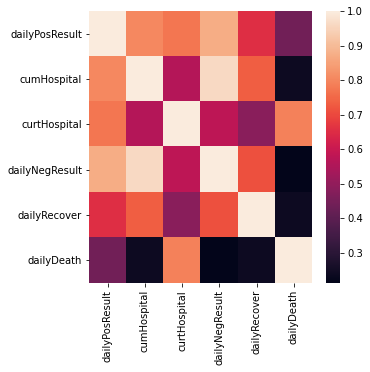

In [18]:
import seaborn as sns
plt.figure(figsize=(5,5))
sns.heatmap(index_df.corr())

## Exploratory Data Analysis (EDA)

In [21]:
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')

In [18]:
index_df.sort_index(inplace = True)

### Plots of daily positive test results and fatalities

**7 Days Rolling Mean & Standard Deviation - Daily Positive Result**

In [22]:
index_df['weekly_mean_posResult'] = index_df['dailyPosResult'].rolling(7).mean()
index_df.fillna(0, inplace = True)

In [24]:
df_daily.head()

date  dailyPosResult
0  2020-01-22             0.0
1  2020-02-12             0.0
2  2020-02-13             0.0
3  2020-02-14             0.0
4  2020-02-16             0.0

In [25]:
df_daily

date  dailyPosResult
0    2020-01-22             0.0
1    2020-02-12             0.0
2    2020-02-13             0.0
3    2020-02-14             0.0
4    2020-02-16             0.0
..          ...             ...
267  2020-07-30         69418.0
268  2020-07-16         71036.0
269  2020-07-23         71553.0
270  2020-07-24         75235.0
271  2020-07-17         76842.0

[272 rows x 2 columns]

In [23]:
#Daily positive test restults
rolmean = index_df['dailyPosResult'].rolling(7).mean()
rolstd = index_df['dailyPosResult'].rolling(7).std()


df_daily = index_df.groupby(index_df.index)['dailyPosResult'].sum().sort_values().reset_index()

fig = px.bar(df_daily.sort_values('dailyPosResult',ascending = False), 
             x='date', y='dailyPosResult',  labels={'date':'Date', 'dailyPosResult': 'Daily Cases'})
fig.update_layout(title_text='Daily Positive COVID-19 Test Results in US')

fig.add_trace(go.Scatter(x=index_df.index, y=rolmean, line=dict(color='red'), name='Rolling Mean'),
              )

fig.add_trace(go.Scatter(x=index_df.index, y=rolstd, line=dict(color='black'), name='Rolling STD'),
              )


fig.show()

**7 Days Rolling Mean & Standard Deviation - Daily Fatalities**

In [21]:
#Daily fatality restults
rolmean_fatal = index_df['dailyDeath'].rolling(7).mean()
rolstd_fatal = index_df['dailyDeath'].rolling(7).std()


df_daily = index_df.groupby(index_df.index)['dailyDeath'].sum().sort_values().reset_index()

fig = px.bar(df_daily.sort_values('dailyDeath',ascending = False), 
             x='date', y='dailyDeath', color_continuous_scale=px.colors.sequential.BuGn)
fig.update_layout(title_text='Daily Fatalities with COVID-19 in US')

fig.add_trace(go.Scatter(x=index_df.index, y=rolmean_fatal, line=dict(color='red'), name='Rolling Mean'),
              )

fig.add_trace(go.Scatter(x=index_df.index, y=rolstd_fatal, line=dict(color='black'), name='Rolling STD'))

fig.show()

## Perform Data Stationary Test

In [22]:
df_copy = index_df[['dailyDeath']]

In [23]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings 
warnings.filterwarnings('ignore')

Split train and test dataset: Let's validate the trained model with the last 10 days observations (10/10/20 - 10/19/20)

In [24]:
# Train model with 90% of data to increase the accuracy
# 0.9 * 272
train_size = 244
train_df, test_df = df_copy[0:train_size], df_copy[train_size:]

Next, let's check whether the data (e.g., Daily Fatalities) is sationary

In [25]:
#Perform Dickey-Fuller test

def check_stationary(ts):
    print('Results of Dickey-Fuller Test:')
    stationary_test = adfuller(ts, autolag='AIC')
    results = pd.Series(stationary_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,val in stationary_test[4].items():
        results['Critical Value (%s)'%key] = val
    print (results)

In [26]:
def plot_stationary(ts):
    rolmean = ts.rolling(7).mean()
    rolstd = ts.rolling(7).std()
    fig = plt.figure(figsize=(10, 8))
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

In [27]:
check_stationary(train_df)

Results of Dickey-Fuller Test:
Test Statistic                  -2.571657
p-value                          0.098998
#Lags Used                      14.000000
Number of Observations Used    229.000000
Critical Value (1%)             -3.459233
Critical Value (5%)             -2.874245
Critical Value (10%)            -2.573541
dtype: float64


In [28]:
train_first_diff = train_df - train_df.shift(1)
train_first_diff = train_first_diff.dropna(inplace = False)
check_stationary(train_first_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -2.649551
p-value                          0.083182
#Lags Used                      13.000000
Number of Observations Used    229.000000
Critical Value (1%)             -3.459233
Critical Value (5%)             -2.874245
Critical Value (10%)            -2.573541
dtype: float64


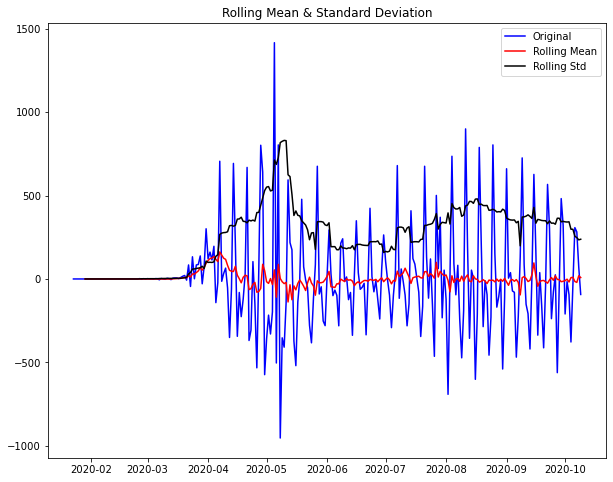

In [43]:
plot_stationary(train_first_diff)

p-value is too high to make the time series into stationary data. Let's dive into other method

## Build the Model 

The ‘auto_arima’ function from the ‘pmdarima’ library will be used to identify the most optimal parameters for an ARIMA model and returns a fitted ARIMA model.

In [29]:
from pmdarima import auto_arima 

Fit auto_arima function to daily fatalities 

### Scenario 1 - (train:test = 90:10)

In [30]:
stepwise_fit = auto_arima(train_df, 
                          start_p = 1, 
                          start_q = 1, 
                          max_p = 10, 
                          max_q = 7, 
                          m = 12, 
                          start_P = 0, 
                          seasonal = True, 
                          d = 1, 
                          D = 1, 
                          trace = True, 
                          random = True,
                          error_action ='ignore',   
                          suppress_warnings = True,   
                          stepwise = True)            
  
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.34 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3505.076, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3426.166, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3506.381, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3358.546, Time=0.55 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.66 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.65 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=3356.764, Time=0.36 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=3428.896, Time=0.22 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.15 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=3358.304, Time=0.53 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=3338.423, Time=1.53 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  244
Model:             SARIMAX(8, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1572.404
Date:                            Wed, 21 Oct 2020   AIC                           3166.809
Time:                                    00:45:54   BIC                           3204.675
Sample:                                         0   HQIC                          3182.081
                                            - 244                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2338      0.120      1.949      0.051      -0.001       0.469
ar.L2         -0.0791      0.071     -1.109      0.267      -0.219       0.061
ar.L3         -0.0405      0.069     -0.583      0.560      -0.177       0.096
ar.L4          0.0660      0.088      0.750      0.453      -0.106       0.238
ar.L5         -0.0610      0.072     -0.848      0.396      -0.202       0.080
ar.L6          0.1409      0.067      2.089      0.037       0.009       0.273
ar.L7          0.6121      0.067      9.200      0.000       0.482       0.742
ar.L8          0.0484      0.123      0.394      0.694      -0.193       0.289
ma.L1         -0.6899      0.097     -7.092      0.000      -0.881      -0.499
ma.S.L12      -0.7615      0.110     -6.946      0.000      -0.976      -0.547
sigma2      5.736e+04   5813.843      9.866      0.000     4.6e+04    6.88e+04
===================================================================================
Ljung-Box (Q):                       55.50   Jarque-Bera (JB):               142.51
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               2.27   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
# Fit a SARIMAX(8, 1, 1)x(0, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
model1 = SARIMAX(train_df,  
                order = (8, 1, 1),  
                seasonal_order =(0, 1, 1, 12)) 
  
result1 = model1.fit() 
result1.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         dailyDeath   No. Observations:                  244
Model:             SARIMAX(8, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1572.404
Date:                            Wed, 21 Oct 2020   AIC                           3166.809
Time:                                    00:53:26   BIC                           3204.675
Sample:                                01-22-2020   HQIC                          3182.081
                                     - 09-21-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2338      0.120      1.949      0.051      -0.001       0.469
ar.L2         -0.0791      0.071     -1.109      0.267      -0.219       0.061
ar.L3         -0.0405      0.069     -0.583      0.560      -0.177       0.096
ar.L4          0.0660      0.088      0.750      0.453      -0.106       0.238
ar.L5         -0.0610      0.072     -0.848      0.396      -0.202       0.080
ar.L6          0.1409      0.067      2.089      0.037       0.009       0.273
ar.L7          0.6121      0.067      9.200      0.000       0.482       0.742
ar.L8          0.0484      0.123      0.394      0.694      -0.193       0.289
ma.L1         -0.6899      0.097     -7.092      0.000      -0.881      -0.499
ma.S.L12      -0.7615      0.110     -6.946      0.000      -0.976      -0.547
sigma2      5.736e+04   5813.843      9.866      0.000     4.6e+04    6.88e+04
===================================================================================
Ljung-Box (Q):                       55.50   Jarque-Bera (JB):               142.51
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               2.27   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
test_df.head()

dailyDeath
date                  
2020-09-22       854.0
2020-09-23      1159.0
2020-09-24       921.0
2020-09-25       844.0
2020-09-26       869.0

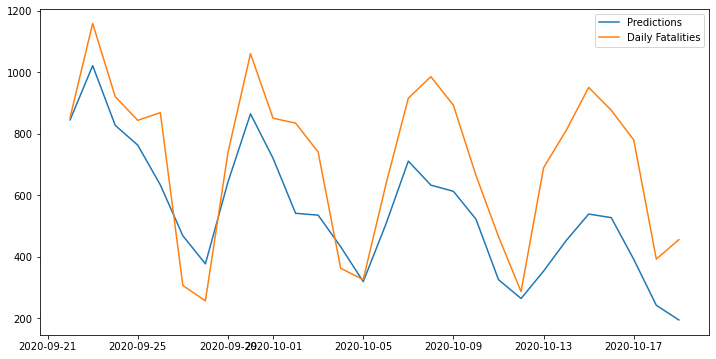

In [34]:
start = "2020-09-22"
end = "2020-10-19"

predictions1 = result1.predict(start, end, typ = 'levels').rename("Predictions")


fig = plt.figure(figsize=(12, 6))
orig = plt.plot(predictions1, label='Predictions')
mean = plt.plot(test_df['dailyDeath'], label='Daily Fatalities')
plt.legend(loc='best')
plt.title('')
plt.show()

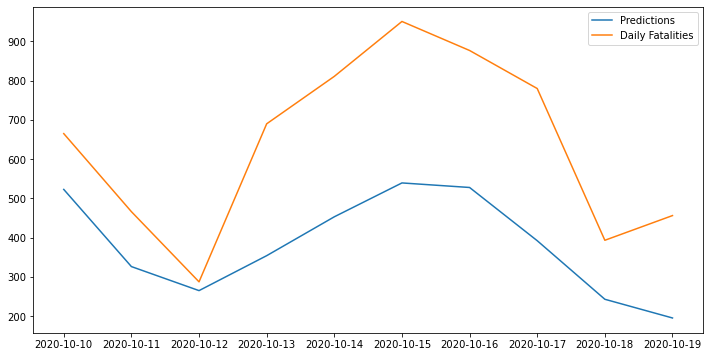

In [49]:
start = "2020-10-10"
end = "2020-10-19"

predictions1 = result1.predict(start, end, typ = 'levels').rename("Predictions")


fig = plt.figure(figsize=(12, 6))
orig = plt.plot(predictions1, label='Predictions')
mean = plt.plot(test_df1['dailyDeath'], label='Daily Fatalities')
plt.legend(loc='best')
plt.title('')
plt.show()

### Scenario 2 - (train:test = 95:5)

In [36]:
train_size = 262
train_df1, test_df1 = df_copy[0:train_size], df_copy[train_size:]

In [37]:
stepwise_fit = auto_arima(train_df1, 
                          start_p = 1, 
                          start_q = 1, 
                          max_p = 10, 
                          max_q = 7, 
                          m = 12, 
                          start_P = 0, 
                          seasonal = True, 
                          d = 1, 
                          D = 1, 
                          trace = True, 
                          random = True,
                          error_action ='ignore',   
                          suppress_warnings = True,   
                          stepwise = True)            
  
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.95 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3780.386, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3696.296, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3781.518, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3619.987, Time=0.56 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.84 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=3618.082, Time=0.36 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=3700.438, Time=0.11 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=3619.850, Time=0.59 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=3596.358, Time=1.59 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=3691.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  262
Model:             SARIMAX(7, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1683.778
Date:                              Wed, 21 Oct 2020   AIC                           3391.557
Time:                                      01:47:47   BIC                           3433.766
Sample:                                           0   HQIC                          3408.547
                                              - 262                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2706      0.080      3.366      0.001       0.113       0.428
ar.L2         -0.1190      0.077     -1.536      0.125      -0.271       0.033
ar.L3         -0.0697      0.074     -0.949      0.343      -0.214       0.074
ar.L4          0.0414      0.084      0.491      0.624      -0.124       0.207
ar.L5          0.0068      0.068      0.100      0.921      -0.127       0.140
ar.L6          0.0462      0.060      0.776      0.438      -0.070       0.163
ar.L7          0.7440      0.068     10.919      0.000       0.610       0.878
ma.L1         -0.7929      0.099     -7.992      0.000      -0.987      -0.598
ma.L2          0.1776      0.092      1.939      0.053      -0.002       0.357
ar.S.L12      -0.2132      0.086     -2.483      0.013      -0.381      -0.045
ma.S.L12      -0.8555      0.102     -8.354      0.000      -1.056      -0.655
sigma2      4.509e+04   4143.518     10.882      0.000     3.7e+04    5.32e+04
===================================================================================
Ljung-Box (Q):                       79.10   Jarque-Bera (JB):               125.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.70   Skew:                             0.22
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
# Fit a SARIMAX(7, 1, 2)x(1, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
model2 = SARIMAX(train_df1,  
                order = (7, 1, 2),  
                seasonal_order =(1, 1, 1, 12)) 
  
result2 = model2.fit() 
result2.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           dailyDeath   No. Observations:                  262
Model:             SARIMAX(7, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1683.778
Date:                              Wed, 21 Oct 2020   AIC                           3391.557
Time:                                      03:22:42   BIC                           3433.766
Sample:                                  01-22-2020   HQIC                          3408.547
                                       - 10-09-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2706      0.080      3.366      0.001       0.113       0.428
ar.L2         -0.1190      0.077     -1.536      0.125      -0.271       0.033
ar.L3         -0.0697      0.074     -0.949      0.343      -0.214       0.074
ar.L4          0.0414      0.084      0.491      0.624      -0.124       0.207
ar.L5          0.0068      0.068      0.100      0.921      -0.127       0.140
ar.L6          0.0462      0.060      0.776      0.438      -0.070       0.163
ar.L7          0.7440      0.068     10.919      0.000       0.610       0.878
ma.L1         -0.7929      0.099     -7.992      0.000      -0.987      -0.598
ma.L2          0.1776      0.092      1.939      0.053      -0.002       0.357
ar.S.L12      -0.2132      0.086     -2.483      0.013      -0.381      -0.045
ma.S.L12      -0.8555      0.102     -8.354      0.000      -1.056      -0.655
sigma2      4.509e+04   4143.518     10.882      0.000     3.7e+04    5.32e+04
===================================================================================
Ljung-Box (Q):                       79.10   Jarque-Bera (JB):               125.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.70   Skew:                             0.22
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

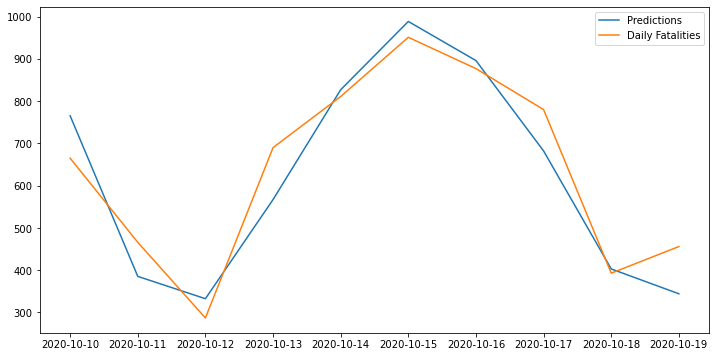

In [56]:
start = "2020-10-10"
end = "2020-10-19"

predictions2 = result2.predict(start, end, typ = 'levels').rename("Predictions")


fig = plt.figure(figsize=(12, 6))
orig = plt.plot(predictions2, label='Predictions')
mean = plt.plot(test_df1['dailyDeath'], label='Daily Fatalities')
plt.legend(loc='best')
plt.title('')
plt.show()

Validation result shown in the figure above looks good! Next, estimate MAPE of the model

In [38]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [46]:
acc1 = mape(test_df['dailyDeath'], predictions1)
print("Mean Absolute Percent Error: {:.2f}%".format(acc1))

Mean Absolute Percent Error: 27.86%


In [47]:
acc2 = mape(test_df1['dailyDeath'], predictions2)
print("Mean Absolute Percent Error: {:.2f}%".format(acc2))

Mean Absolute Percent Error: 13.99%


## Forecast Fatalities

### Scenario 1: Vaccine is available at the end of first quarter in 2021

- Start: 2020-10-20 
- End: 2021-03-31

<AxesSubplot:xlabel='date'>

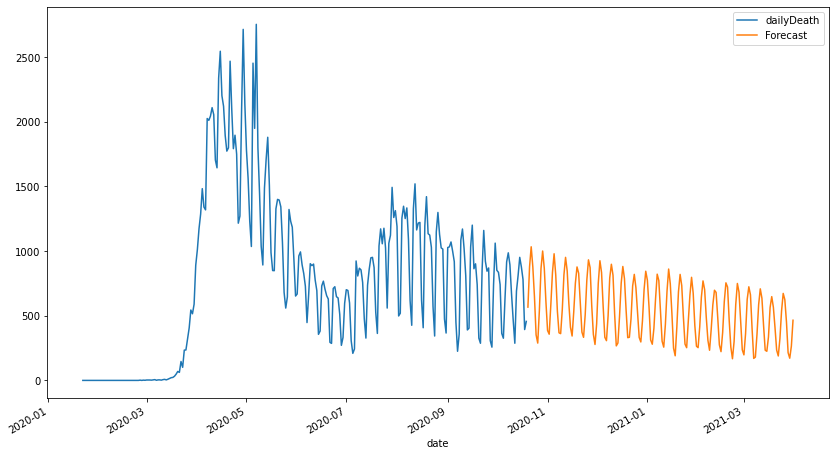

In [58]:
#Start: 10/20/20 
#End: 12/31/21

forecast1 = result2.predict(start = "2020-10-20",
                            end = '2021-03-31',                        
                            typ = 'levels').rename('Forecast') 
  
# Plot the forecast values 
df_copy['dailyDeath'].plot(figsize = (14, 8), legend = True) 
forecast1.plot(legend = True) 

In [59]:
fcast1 = result2.get_forecast(173)
print('Forecast:')
print(fcast1.predicted_mean)
print('Confidence intervals:')
print(fcast1.conf_int(alpha=0.1))

Forecast:
2020-10-10    765.388530
2020-10-11    385.410905
2020-10-12    332.586842
2020-10-13    567.109510
2020-10-14    826.961929
                 ...    
2021-03-27    451.868376
2021-03-28    214.392721
2021-03-29    171.540379
2021-03-30    265.130263
2021-03-31    464.903348
Freq: D, Length: 173, dtype: float64
Confidence intervals:
            lower dailyDeath  upper dailyDeath
2020-10-10        416.047052       1114.730008
2020-10-11         -1.748708        772.570517
2020-10-12        -78.426846        743.600530
2020-10-13        136.770810        997.448210
2020-10-14        369.458889       1284.464969
...                      ...               ...
2021-03-27     -22712.027541      23615.764293
2021-03-28     -23153.288562      23582.074004
2021-03-29     -23397.303997      23740.384755
2021-03-30     -23496.862473      24027.122999
2021-03-31     -23485.773829      24415.580525

[173 rows x 2 columns]


In [60]:
upper_1 = fcast1.conf_int(alpha=0.1).iloc[10:,1]
lower_1 = fcast1.conf_int(alpha=0.1).iloc[10:,0]

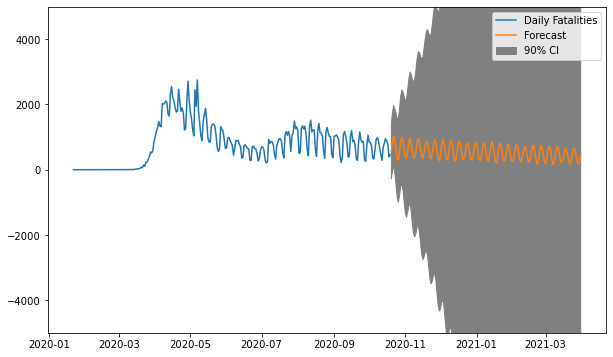

In [63]:
plt.figure(figsize=(10,6))
# X-axis
x1 = df_copy['dailyDeath'].index
x2 = forecast1.index

# Y-axis
y1 = df_copy['dailyDeath']
y2 = forecast1
y3 = fcast1.conf_int(alpha=0.1)['lower dailyDeath'].iloc[10:]
y4 = fcast1.conf_int(alpha=0.1)['upper dailyDeath'].iloc[10:]

# Set y-limit
plt.ylim(-5000, 5000)
# Plotting of lines
plt.plot(x1, y1, label = 'Daily Fatalities')
plt.plot(x2, y2, label = 'Forecast')
plt.fill_between(x2, y3, y4, color='grey', label = '90% CI')
plt.legend()
plt.show()

### Scenario 2: Vaccine is not available until the end of 2021

- Start: 2020-10-20 
- End: 2021-06-30

<AxesSubplot:xlabel='date'>

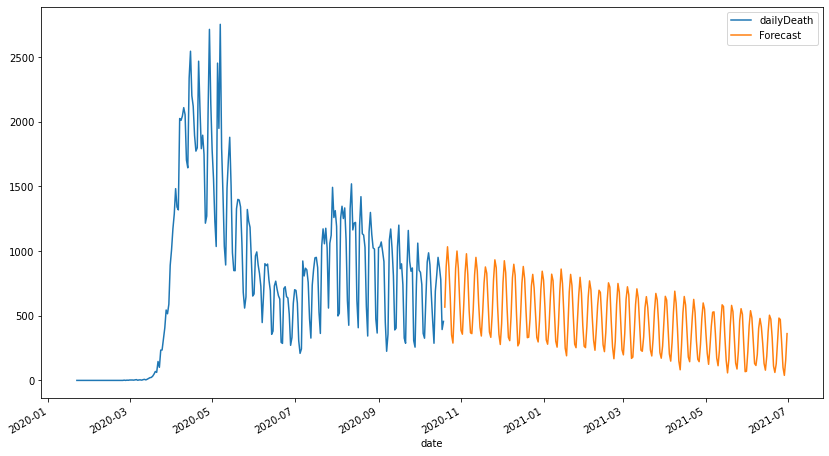

In [64]:
forecast2 = result2.predict(start = "2020-10-20",
                            end = '2021-06-30',                        
                            typ = 'levels').rename('Forecast') 
  
# Plot the forecast values 
df_copy['dailyDeath'].plot(figsize = (14, 8), legend = True) 
forecast2.plot(legend = True) 

In [76]:
fcast2 = result2.get_forecast(264)
print('Forecast:')
print(fcast2.predicted_mean)
print('Confidence intervals:')
print(fcast2.conf_int(alpha=0.1))

Forecast:
2020-10-10    765.388530
2020-10-11    385.410905
2020-10-12    332.586842
2020-10-13    567.109510
2020-10-14    826.961929
                 ...    
2021-06-26    293.121014
2021-06-27    100.272528
2021-06-28     38.864465
2021-06-29    157.191675
2021-06-30    361.533600
Freq: D, Length: 264, dtype: float64
Confidence intervals:
            lower dailyDeath  upper dailyDeath
2020-10-10        416.047052       1114.730008
2020-10-11         -1.748708        772.570517
2020-10-12        -78.426846        743.600530
2020-10-13        136.770810        997.448210
2020-10-14        369.458889       1284.464969
...                      ...               ...
2021-06-26     -42695.845087      43282.087116
2021-06-27     -43133.976546      43334.521602
2021-06-28     -43438.170154      43515.899084
2021-06-29     -43556.963606      43871.346956
2021-06-30     -43586.169623      44309.236824

[264 rows x 2 columns]


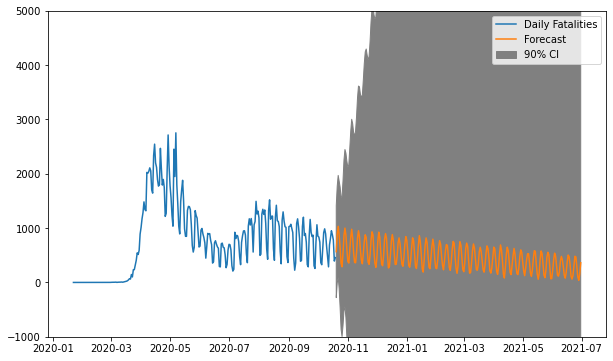

In [77]:
plt.figure(figsize=(10,6))
# X-axis
x1 = df_copy['dailyDeath'].index
x2 = forecast2.index

# Y-axis
y1 = df_copy['dailyDeath']
y2 = forecast2
y3 = fcast2.conf_int(alpha=0.1)['lower dailyDeath'].iloc[10:]
y4 = fcast2.conf_int(alpha=0.1)['upper dailyDeath'].iloc[10:]

# Set y-limit
plt.ylim(-1000, 5000)
# Plotting of lines
plt.plot(x1, y1, label = 'Daily Fatalities')
plt.plot(x2, y2, label = 'Forecast')
plt.fill_between(x2, y3, y4, color='grey', label = '90% CI')
plt.legend()
plt.show()

### Scenario 3: Vaccine is not available until the end of 2021

<AxesSubplot:xlabel='date'>

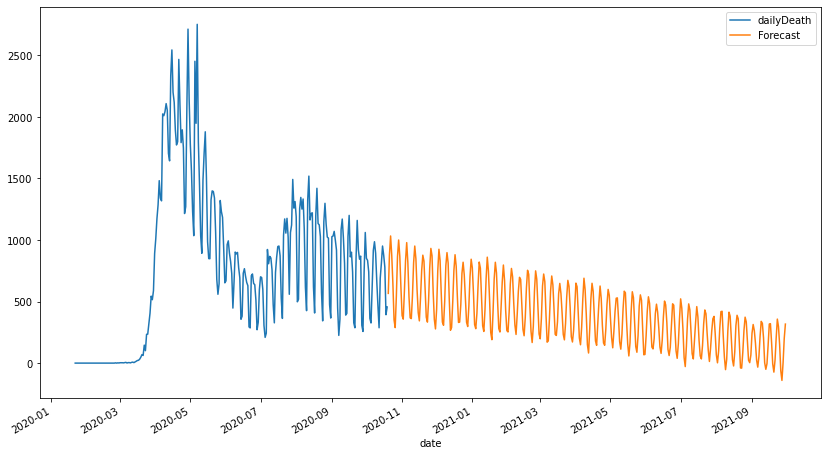

In [79]:
forecast3 = result2.predict(start = "2020-10-20",
                            end = '2021-09-30',                        
                            typ = 'levels').rename('Forecast') 
  
# Plot the forecast values 
df_copy['dailyDeath'].plot(figsize = (14, 8), legend = True) 
forecast3.plot(legend = True) 

In [81]:
fcast3 = result2.get_forecast(356)
print('Forecast:')
print(fcast3.predicted_mean)
print('Confidence intervals:')
print(fcast3.conf_int(alpha=0.1))

Forecast:
2020-10-10    765.388530
2020-10-11    385.410905
2020-10-12    332.586842
2020-10-13    567.109510
2020-10-14    826.961929
                 ...    
2021-09-26    -62.973545
2021-09-27   -140.480423
2021-09-28      3.808429
2021-09-29    200.782755
2021-09-30    316.920968
Freq: D, Length: 356, dtype: float64
Confidence intervals:
            lower dailyDeath  upper dailyDeath
2020-10-10        416.047052       1114.730008
2020-10-11         -1.748708        772.570517
2020-10-12        -78.426846        743.600530
2020-10-13        136.770810        997.448210
2020-10-14        369.458889       1284.464969
...                      ...               ...
2021-09-26     -66801.937370      66675.990280
2021-09-27     -67158.595024      66877.634178
2021-09-28     -67289.092798      67296.709655
2021-09-29     -67364.005141      67765.570651
2021-09-30     -67522.416345      68156.258280

[356 rows x 2 columns]


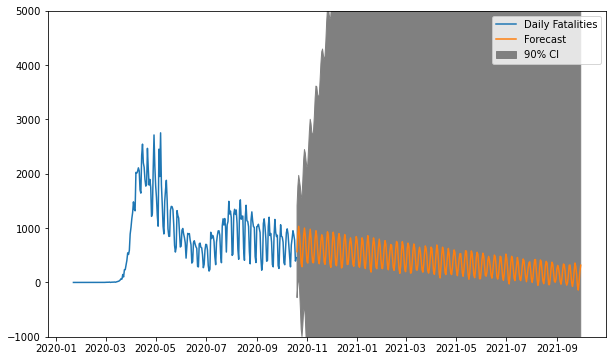

In [82]:
plt.figure(figsize=(10,6))
# X-axis
x1 = df_copy['dailyDeath'].index
x2 = forecast3.index

# Y-axis
y1 = df_copy['dailyDeath']
y2 = forecast3
y3 = fcast3.conf_int(alpha=0.1)['lower dailyDeath'].iloc[10:]
y4 = fcast3.conf_int(alpha=0.1)['upper dailyDeath'].iloc[10:]

# Set y-limit
plt.ylim(-1000, 5000)
# Plotting of lines
plt.plot(x1, y1, label = 'Daily Fatalities')
plt.plot(x2, y2, label = 'Forecast')
plt.fill_between(x2, y3, y4, color='grey', label = '90% CI')
plt.legend()
plt.show()

### Scenario 4: Vaccine is not available until the end of 2021

- Start: 2020-10-20 
- End: 2021-12-31

<AxesSubplot:xlabel='date'>

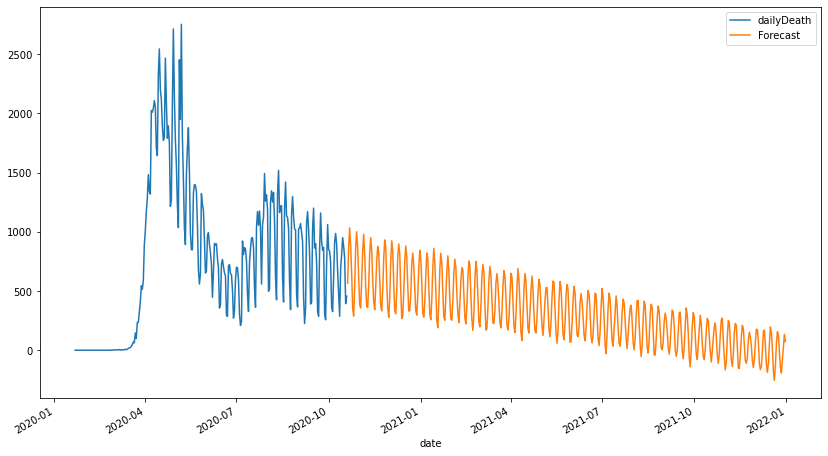

In [57]:
#Start: 10/20/20 
#End: 12/31/21

forecast4 = result2.predict(start = "2020-10-20",
                            end = '2021-12-31',                        
                            typ = 'levels').rename('Forecast') 
  
# Plot the forecast values 
df_copy['dailyDeath'].plot(figsize = (14, 8), legend = True) 
forecast4.plot(legend = True) 



### Estimate 90% Confidence Interval 

In [67]:
fcast4 = result2.get_forecast(448)
print('Forecast:')
print(fcast4.predicted_mean)
print('Confidence intervals:')
print(fcast4.conf_int(alpha=0.1))

Forecast:
2020-10-10    765.388530
2020-10-11    385.410905
2020-10-12    332.586842
2020-10-13    567.109510
2020-10-14    826.961929
                 ...    
2021-12-27   -192.760031
2021-12-28    -85.839734
2021-12-29     23.338414
2021-12-30    134.360029
2021-12-31     74.088661
Freq: D, Length: 448, dtype: float64
Confidence intervals:
            lower dailyDeath  upper dailyDeath
2020-10-10        416.047052       1114.730008
2020-10-11         -1.748708        772.570517
2020-10-12        -78.426846        743.600530
2020-10-13        136.770810        997.448210
2020-10-14        369.458889       1284.464969
...                      ...               ...
2021-12-27     -93887.464053      93501.943991
2021-12-28     -94090.906438      93919.226971
2021-12-29     -94287.850705      94334.527532
2021-12-30     -94484.184876      94752.904934
2021-12-31     -94854.011023      95002.188344

[448 rows x 2 columns]


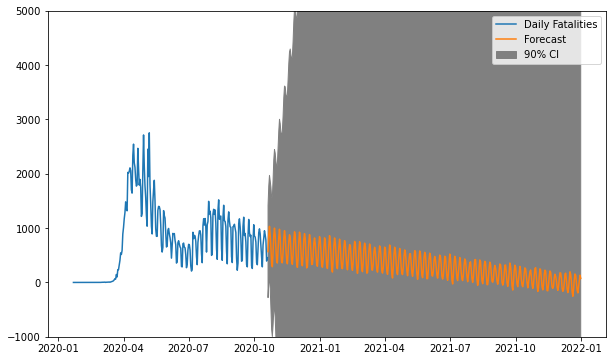

In [75]:
plt.figure(figsize=(10,6))
# X-axis
x1 = df_copy['dailyDeath'].index
x2 = forecast4.index

# Y-axis
y1 = df_copy['dailyDeath']
y2 = forecast4
y3 = fcast4.conf_int(alpha=0.1)['lower dailyDeath'].iloc[10:]
y4 = fcast4.conf_int(alpha=0.1)['upper dailyDeath'].iloc[10:]

# Set y-limit
plt.ylim(-1000, 5000)
# Plotting of lines
plt.plot(x1, y1, label = 'Daily Fatalities')
plt.plot(x2, y2, label = 'Forecast')
plt.fill_between(x2, y3, y4, color='grey', label = '90% CI')
plt.legend()
plt.show()

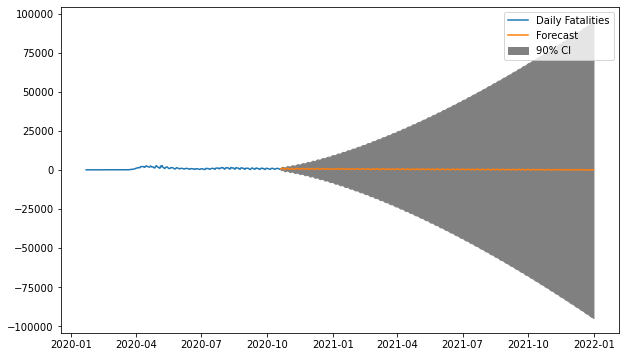

In [78]:
plt.figure(figsize=(10,6))
# X-axis
x1 = df_copy['dailyDeath'].index
x2 = forecast4.index

# Y-axis
y1 = df_copy['dailyDeath']
y2 = forecast4
y3 = fcast4.conf_int(alpha=0.1)['lower dailyDeath'].iloc[10:]
y4 = fcast4.conf_int(alpha=0.1)['upper dailyDeath'].iloc[10:]

# Set y-limit
#plt.ylim(-1000, 5000)
# Plotting of lines
plt.plot(x1, y1, label = 'Daily Fatalities')
plt.plot(x2, y2, label = 'Forecast')
plt.fill_between(x2, y3, y4, color='grey', label = '90% CI')
plt.legend()
plt.show()

In [95]:
fatalities = [forecast1, forecast2, forecast3, forecast4]

def forecast(data):
    for i in data:
        total = i.sum()
        print("Total fatalities caused by COVID-19: {:.0f}".format(total))
        

In [96]:
forecast(fatalities)

Total fatalities caused by COVID-19: 88015
Total fatalities caused by COVID-19: 118467
Total fatalities caused by COVID-19: 135773
Total fatalities caused by COVID-19: 139370


In [210]:
df_copy.reset_index().head(300)

date  dailyDeath
0    2020-01-22         0.0
1    2020-01-23         0.0
2    2020-01-24         0.0
3    2020-01-25         0.0
4    2020-01-26         0.0
5    2020-01-27         0.0
6    2020-01-28         0.0
7    2020-01-29         0.0
8    2020-01-30         0.0
9    2020-01-31         0.0
10   2020-02-01         0.0
11   2020-02-02         0.0
12   2020-02-03         0.0
13   2020-02-04         0.0
14   2020-02-05         0.0
15   2020-02-06         0.0
16   2020-02-07         0.0
17   2020-02-08         0.0
18   2020-02-09         0.0
19   2020-02-10         0.0
20   2020-02-11         0.0
21   2020-02-12         0.0
22   2020-02-13         0.0
23   2020-02-14         0.0
24   2020-02-15         0.0
25   2020-02-16         0.0
26   2020-02-17         0.0
27   2020-02-18         0.0
28   2020-02-19         0.0
29   2020-02-20         0.0
30   2020-02-21         0.0
31   2020-02-22         0.0
32   2020-02-23         0.0
33   2020-02-24         0.0
34   2020-02-25         0.0
35   2020-02-26         2.0
36   2020-02-27         0.0
37   2020-02-28         2.0
38   2020-02-29         1.0
39   2020-03-01         3.0
40   2020-03-02         3.0
41   2020-03-03         3.0
42   2020-03-04         2.0
43   2020-03-05         4.0
44   2020-03-06         6.0
45   2020-03-07         1.0
46   2020-03-08         4.0
47   2020-03-09         4.0
48   2020-03-10         2.0
49   2020-03-11         6.0
50   2020-03-12         8.0
51   2020-03-13         4.0
52   2020-03-14         9.0
53   2020-03-15        15.0
54   2020-03-16        21.0
55   2020-03-17        23.0
56   2020-03-18        32.0
57   2020-03-19        48.0
58   2020-03-20        69.0
59   2020-03-21        62.0
60   2020-03-22       146.0
61   2020-03-23       101.0
62   2020-03-24       234.0
63   2020-03-25       235.0
64   2020-03-26       319.0
65   2020-03-27       406.0
66   2020-03-28       544.0
67   2020-03-29       515.0
68   2020-03-30       589.0
69   2020-03-31       890.0
70   2020-04-01      1011.0
71   2020-04-02      1172.0
72   2020-04-03      1286.0
73   2020-04-04      1482.0
74   2020-04-05      1340.0
75   2020-04-06      1318.0
76   2020-04-07      2024.0
77   2020-04-08      2010.0
78   2020-04-09      2043.0
79   2020-04-10      2108.0
80   2020-04-11      2054.0
81   2020-04-12      1703.0
82   2020-04-13      1643.0
83   2020-04-14      2336.0
84   2020-04-15      2544.0
85   2020-04-16      2200.0
86   2020-04-17      2119.0
87   2020-04-18      1893.0
88   2020-04-19      1772.0
89   2020-04-20      1798.0
90   2020-04-21      2467.0
91   2020-04-22      2098.0
92   2020-04-23      1791.0
93   2020-04-24      1895.0
94   2020-04-25      1748.0
95   2020-04-26      1215.0
96   2020-04-27      1270.0
97   2020-04-28      2072.0
98   2020-04-29      2713.0
99   2020-04-30      2139.0
100  2020-05-01      1779.0
101  2020-05-02      1562.0
102  2020-05-03      1232.0
103  2020-05-04      1035.0
104  2020-05-05      2452.0
105  2020-05-06      1948.0
106  2020-05-07      2752.0
107  2020-05-08      1798.0
108  2020-05-09      1445.0
109  2020-05-10      1036.0
110  2020-05-11       892.0
111  2020-05-12      1486.0
112  2020-05-13      1704.0
113  2020-05-14      1879.0
114  2020-05-15      1507.0
115  2020-05-16       987.0
116  2020-05-17       849.0
117  2020-05-18       848.0
118  2020-05-19      1326.0
119  2020-05-20      1399.0
120  2020-05-21      1394.0
121  2020-05-22      1341.0
122  2020-05-23      1063.0
123  2020-05-24       680.0
124  2020-05-25       559.0
125  2020-05-26       645.0
126  2020-05-27      1321.0
127  2020-05-28      1231.0
128  2020-05-29      1184.0
129  2020-05-30       932.0
130  2020-05-31       652.0
131  2020-06-01       668.0
132  2020-06-02       962.0
133  2020-06-03       993.0
134  2020-06-04       893.0
135  2020-06-05       826.0
136  2020-06-06       728.0
137  2020-06-07       447.0
138  2020-06-08       661.0
139  2020-06-09       902.0
140  2020-06-10       887.0
141  2020-06-11       899.0
142  20